## Import libraries

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps
from ast import literal_eval

## Load data from OA and Grobid detection

In [42]:
papers_info = pd.read_csv("../../Results/extraction/papers_infos_openalex.csv")
ds_info = pd.read_csv("../../Resources/data/datasets.csv")

In [43]:
#All datasets
#datasets_columns = ds_info["name"].to_list()

#For the poster
datasets_columns = ["BRATS","DRIVE","Chexpert","MIMIC"]

datasets_columns.sort()
selected_venues = ["MICCAI","MIDL"]

In [44]:
df_detection = pd.read_csv("../../Results/extraction/grobid_fulltext_detection.csv")
df_oa_abstract = pd.read_csv("../../Results/extraction/oa_papers_datasets_abstract.csv")
df_grobid_references = pd.read_csv("../../Results/extraction/grobid_reference_detection.csv")

df_oa_ref = pd.read_csv("../../Results/extraction/oa_papers_datasets_reference.csv")
ref_format_annotation = []
for row in df_oa_ref.iterrows():
    row_value = row[1]
    for ds in datasets_columns:
        if row_value[ds]:
            ref_format_annotation.append((row_value["name"],ds,True))
        else:
            ref_format_annotation.append((row_value["name"],ds,False))
df_oa_references = pd.DataFrame(ref_format_annotation,columns=["doc_name","label1","value"])

papers_info["downloaded_fulltext"] = papers_info["title"].apply(lambda x: x in df_grobid_references["doc_name"].unique())

### Get number of extracted papers per venue

In [45]:
import glob
papers_name = [p.removeprefix("../../Results/extraction/fulltext/").removesuffix(".pdf") for p in glob.glob("../../Results/extraction/fulltext/*")]
nb_downloaded = 0
nb_venue = {"MICCAI":0,"MIDL":0,"CHIL":0}
for p in papers_name:
    if p in papers_info["title"].unique():
        nb_downloaded += 1
        nb_venue[papers_info[papers_info["title"]==p]["venue"].to_numpy()[0]] += 1
print(nb_downloaded)
print(nb_venue)

2635
{'MICCAI': 2291, 'MIDL': 262, 'CHIL': 82}


## Merge references

In [46]:
df_references = pd.concat([df_grobid_references,df_oa_references])
df_references = df_references.sort_values(by=["value"],ascending=False)
df_references = df_references.drop_duplicates(subset=["doc_name","label1"],keep="first")
df_references = df_references.sort_values(by=["doc_name","label1"])

## Transform and merge detections from Grobid and OpenAlex

In [47]:
#Merge oa abstract and grobid detection
for row in df_oa_abstract.iterrows():
    row_value = row[1]
    for ds in datasets_columns:
        if row_value[ds]:
            if row_value["name"] in df_detection["doc_name"].unique():
                df_detection[(df_detection["doc_name"]==row_value["name"])&(df_detection["label1"]==ds)&(df_detection["label2"]=="In abstract")]["value"]=True
            else:
                new_row = {"doc_name":[row_value["name"]],"label1":[ds],"label2":["In Abstract"],"value":[True]}
                df_detection = pd.concat([df_detection,pd.DataFrame(new_row)],ignore_index=True)

In [48]:
def get_venue(doc_name):
    if doc_name in papers_info["title"].unique():
        return papers_info[papers_info["title"]==doc_name]["venue"].to_list()[0]
    return "None"
df_detection["venue"] = df_detection["doc_name"].apply(get_venue)
df_references["venue"] = df_references["doc_name"].apply(get_venue)
df_detection = df_detection[df_detection["venue"].isin(selected_venues)]
df_references = df_references[df_references["venue"].isin(selected_venues)]

def get_year(doc_name):
    if doc_name in papers_info["title"].unique():
        return papers_info[papers_info["title"]==doc_name]["year"].to_list()[0]
    return 0
df_detection["year"] = df_detection["doc_name"].apply(get_year)
df_references["year"] = df_references["doc_name"].apply(get_year)

df_references = df_references[df_references["venue"].isin(selected_venues)]

In [49]:
papers_info[papers_info["venue"].isin(selected_venues)].groupby("venue").count()["title"]

venue
MICCAI    4569
MIDL       266
Name: title, dtype: int64

## Discard papers for which we only have OpenAlex abstract (no full-text and references) or only the list of references from OpenAlex (no abstract or full-text)

In [50]:
discard_group1 = (papers_info["downloaded_fulltext"]==False) & (papers_info["references"].isna()) & (~papers_info["abstract"].isna())
discard_group2 = (papers_info["downloaded_fulltext"]==False) & (~papers_info["references"].isna()) & (papers_info["abstract"].isna())
mask_discarded_papers = discard_group1 | discard_group2
name_paper_to_keep = papers_info[~mask_discarded_papers]["title"].unique()

In [51]:
df_references = df_references[df_references["doc_name"].isin(name_paper_to_keep)]
df_detection = df_detection[df_detection["doc_name"].isin(name_paper_to_keep)]

## Visualisation

In [52]:
def match_citation_mention(doc_name,label,df_detection):
    if doc_name in df_detection["doc_name"].unique():
        if df_detection[(df_detection["doc_name"] == doc_name) & (df_detection["label1"] == label) & (df_detection["label2"] != "Elsewhere")]["value"].any():
            return True
    return False
    
total_citation = len(df_references[df_references["value"]])
cited_and_mentioned = df_references[df_references["value"]].apply(lambda x:match_citation_mention(x["doc_name"],x["label1"],df_detection),axis=1)
only_cited = ~cited_and_mentioned

In [53]:
def match_mention_citation(doc_name,label,df_references):
    if doc_name in df_references["doc_name"].unique():
        if df_references[(df_references["doc_name"] == doc_name) & (df_references["label1"] == label)]["value"].any():
            return True
    return False

df_detection_merge_dataset = df_detection[(df_detection["value"]) & (df_detection["label2"] != "Elsewhere")].drop_duplicates(subset=["doc_name","label1"])
total_detection = len(df_detection_merge_dataset)
mentioned_and_cited = df_detection_merge_dataset.apply(lambda x:match_mention_citation(x["doc_name"],x["label1"],df_references),axis=1)
only_mentioned = ~mentioned_and_cited

In [54]:
count_mention_cited_dataset_venue = df_detection_merge_dataset[mentioned_and_cited].groupby(["label1","venue"]).count()["value"].unstack().fillna(0)[selected_venues]
count_mention_dataset_venue = df_detection_merge_dataset[only_mentioned].groupby(["label1","venue"]).count()["value"].unstack().fillna(0)[selected_venues]
count_cited_dataset_venue = df_references[df_references["value"]][only_cited].groupby(["label1","venue"]).count()["value"].unstack().fillna(0)[selected_venues]
total_presence_dataset_venue = count_cited_dataset_venue.add(count_mention_cited_dataset_venue,fill_value=0).add(count_mention_dataset_venue,fill_value=0)[selected_venues]

In [55]:
perc_citation_venue = ((count_cited_dataset_venue / total_presence_dataset_venue) * 100).fillna(0).T
perc_mention_venue = ((count_mention_dataset_venue / total_presence_dataset_venue) * 100).fillna(0).T
perc_both_venue = ((count_mention_cited_dataset_venue / total_presence_dataset_venue) * 100).fillna(0).T

In [56]:
dataset_present = sorted(set(datasets_columns) & set(perc_mention_venue.columns))

### Presence’s type stackbar plot per venue and dataset

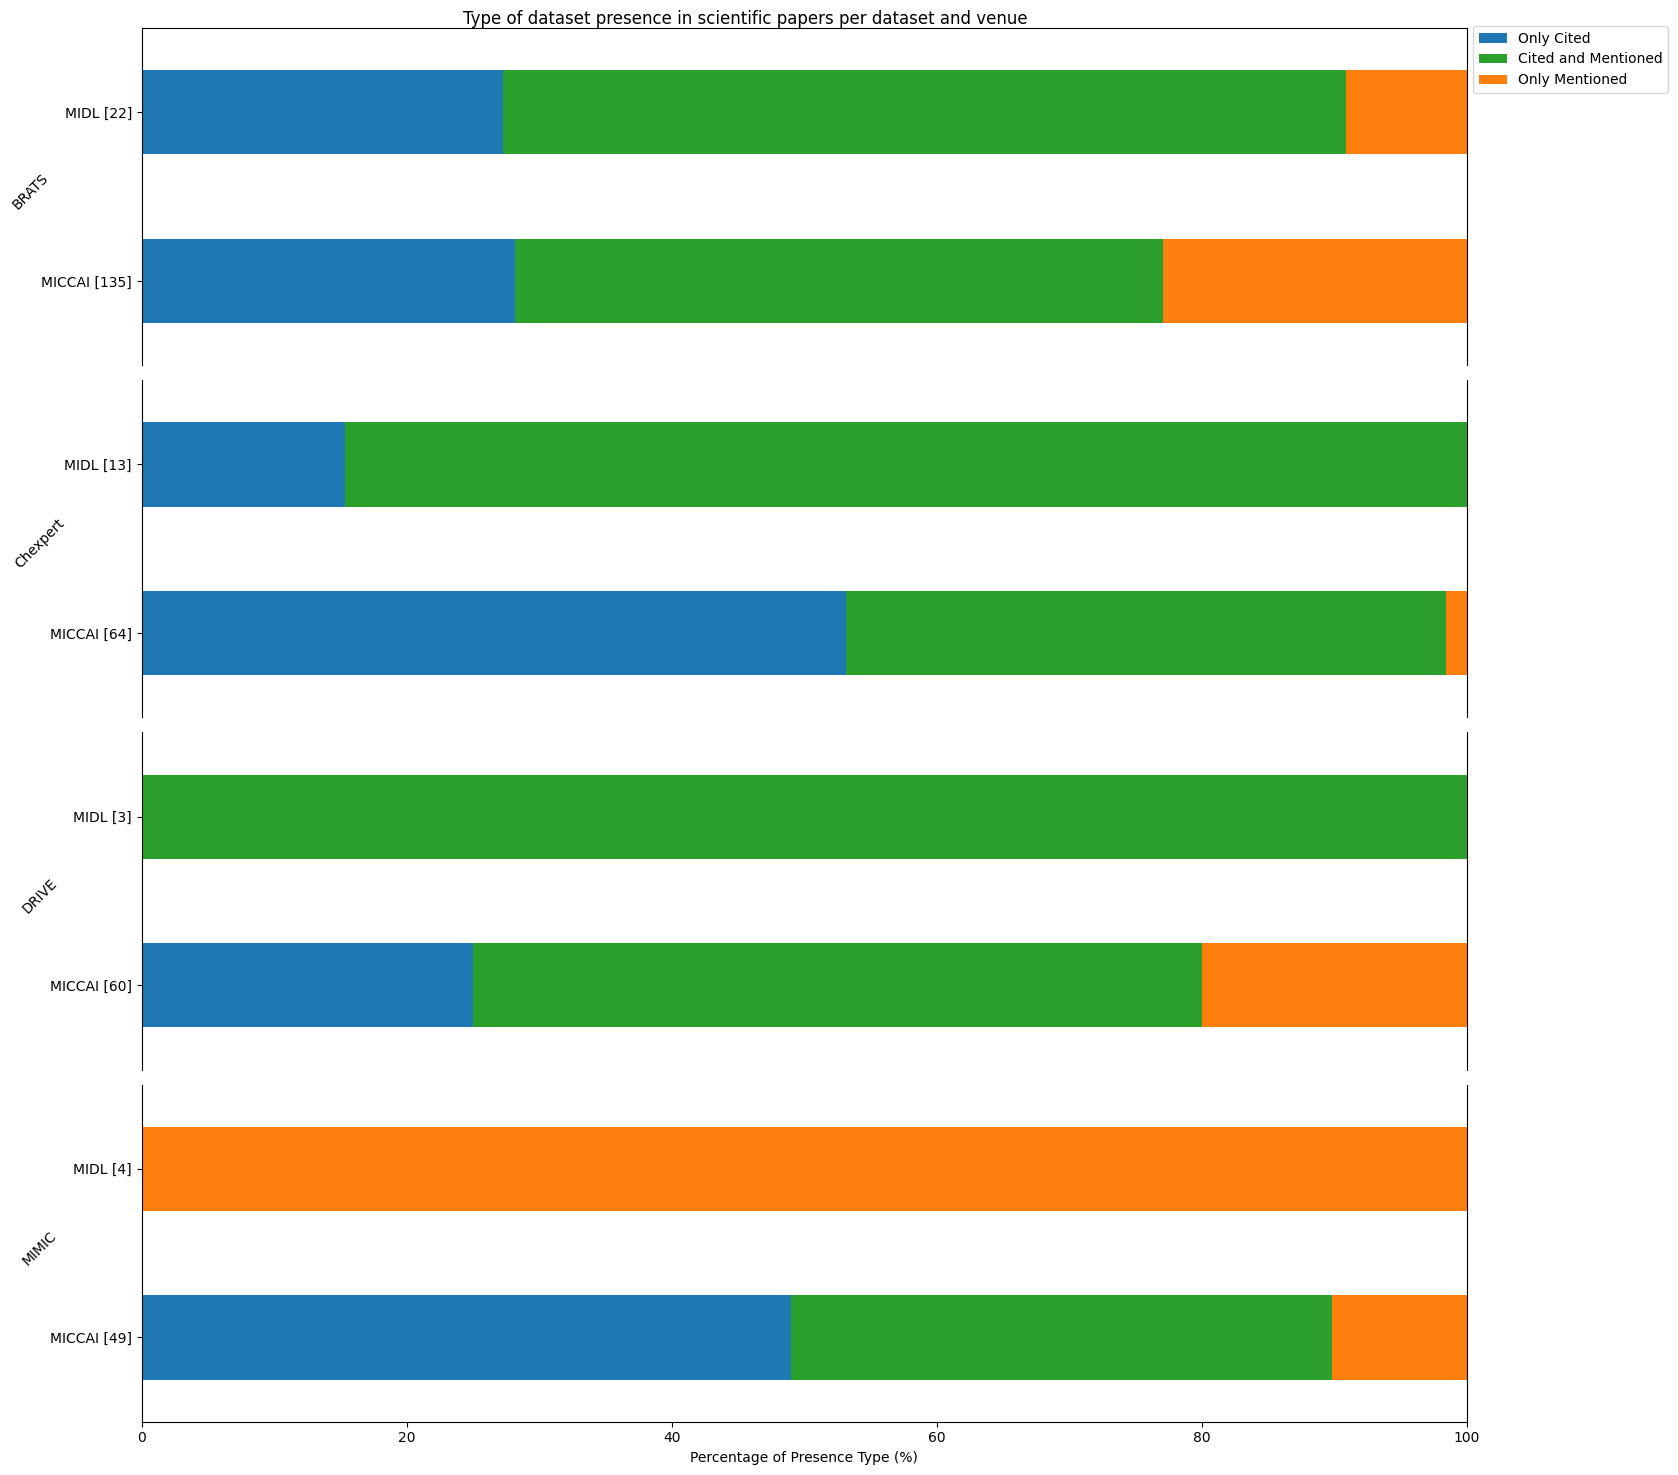

In [57]:
f,axes = plt.subplots(len(dataset_present),1,figsize=(15,15))
for i,dataset in enumerate(dataset_present):
    ax = axes[i]
    mention_per = perc_mention_venue[dataset]
    cite_per = perc_citation_venue[dataset]
    both_per = perc_both_venue[dataset]
    df = pd.DataFrame(data=[cite_per,both_per,mention_per])
    df.index = ["Only Cited","Cited and Mentioned", "Only Mentioned"]
    ax = df.T.plot.barh(stacked=True,ax=ax,color=["#1f77b4","#2ca02c","#ff7f0e"])
    ax.get_legend().remove()
    ax.set_ylabel(dataset,rotation=45)
    ax.set_yticklabels([f"{venue} [{int(total_presence_dataset_venue.loc[dataset][venue])}]" for venue in total_presence_dataset_venue.loc[dataset].index])
    ax.get_xaxis().set_visible(False)
    ax.set_xlim(0,100)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

axes[0].spines["top"].set_visible(True)
ax.spines["bottom"].set_visible(True)
ax.get_xaxis().set_visible(True)
ax.set_xlabel("Percentage of Presence Type (%)")
handles, labels = ax.get_legend_handles_labels()
f.legend(handles, labels,bbox_to_anchor=(1.12, 0.974))
plt.suptitle("Type of dataset presence in scientific papers per dataset and venue")
f.tight_layout()


In [58]:
total_presence_dataset_venue

venue,MICCAI,MIDL
label1,,
ACDC,48.0,8.0
BRATS,135.0,22.0
CADDementia,1.0,0.0
CAMELYON,14.0,8.0
CBIS-DDSM,7.0,0.0
ChestX-Ray14,45.0,8.0
Chexpert,64.0,13.0
DRIVE,60.0,3.0
LIDC-IDRI,36.0,3.0


## Cumulative count of mentions per year and dataset

<Figure size 640x480 with 0 Axes>

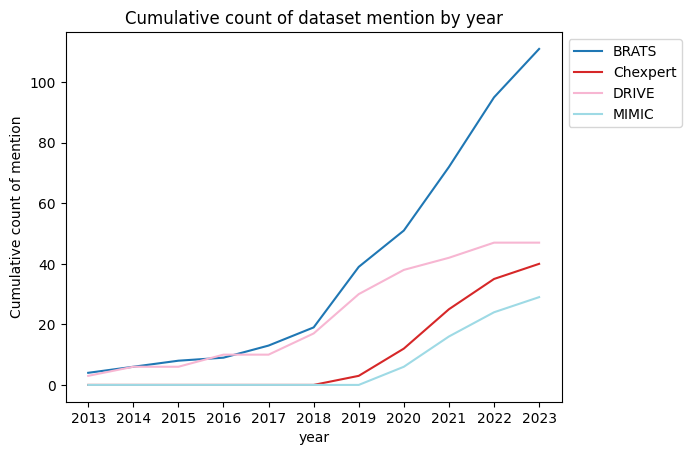

In [59]:
cumulcount_per_dataset_and_year = df_detection[df_detection["value"] &(df_detection["label1"].isin(datasets_columns)) & (df_detection["year"]!=0) & (df_detection["label2"] != "Elsewhere")].drop_duplicates(subset=["doc_name","label1","value"]).groupby(["label1","year"])["value"].sum().unstack().fillna(0).cumsum(axis=1).T
plt.figure()
cmap = colormaps.get_cmap('tab20')
cumulcount_per_dataset_and_year.plot(cmap=cmap)
plt.ylabel("Cumulative count of mention")
plt.xticks([int(year) for year in cumulcount_per_dataset_and_year.index])
plt.title("Cumulative count of dataset mention by year")
plt.legend(bbox_to_anchor=(1,1))
plt.show()

## Cumulative count of citations per year and dataset

<Figure size 640x480 with 0 Axes>

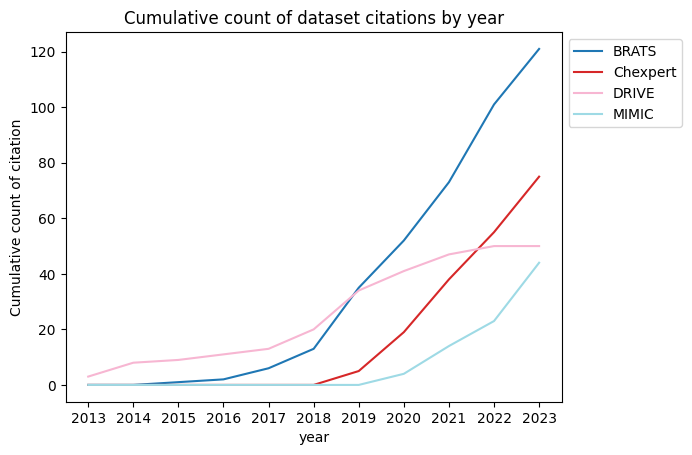

In [60]:
cumulcount_per_dataset_and_year = df_references[(df_references["value"]) & (df_references["label1"].isin(datasets_columns))].groupby(["label1","year"])["value"].sum().unstack().fillna(0).cumsum(axis=1).T

plt.figure()
cmap = colormaps.get_cmap('tab20')
cumulcount_per_dataset_and_year.plot(cmap=cmap)
plt.ylabel("Cumulative count of citation")
plt.xticks([int(year) for year in cumulcount_per_dataset_and_year.index])
plt.title("Cumulative count of dataset citations by year")
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [61]:
cumulcount_per_dataset_and_year.T

year,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0
label1,,,,,,,,,,,
BRATS,0.0,0.0,1.0,2.0,6.0,13.0,35.0,52.0,73.0,101.0,121.0
Chexpert,0.0,0.0,0.0,0.0,0.0,0.0,5.0,19.0,38.0,55.0,75.0
DRIVE,3.0,8.0,9.0,11.0,13.0,20.0,34.0,41.0,47.0,50.0,50.0
MIMIC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,14.0,23.0,44.0


<Figure size 640x480 with 0 Axes>

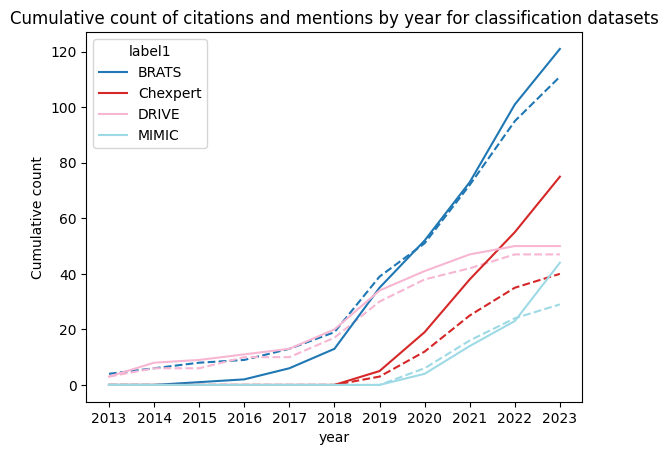

In [62]:
plt.figure()
cmap = colormaps.get_cmap('tab20')
cumulcount_per_dataset_and_year = df_detection[(df_detection["value"]) &(df_detection["label1"].isin(datasets_columns)) & (df_detection["year"]!=0) & (df_detection["label2"] != "Elsewhere")].drop_duplicates(subset=["doc_name","label1","value"]).groupby(["label1","year"])["value"].sum().unstack().fillna(0).cumsum(axis=1).T
for ds in datasets_columns:
    if ds not in cumulcount_per_dataset_and_year:
        cumulcount_per_dataset_and_year[ds] = [0] * len(cumulcount_per_dataset_and_year.index) 
cumulcount_per_dataset_and_year = cumulcount_per_dataset_and_year.reindex(sorted(cumulcount_per_dataset_and_year.columns), axis=1)
ax = cumulcount_per_dataset_and_year.plot(cmap=cmap,style="--",legend=False)

cumulcount_per_dataset_and_year = df_references[(df_references["value"]) &(df_references["label1"].isin(datasets_columns))].groupby(["label1","year"])["value"].sum().unstack().fillna(0).cumsum(axis=1).T
for ds in datasets_columns:
    if ds not in cumulcount_per_dataset_and_year:
        cumulcount_per_dataset_and_year[ds] = [0] * len(cumulcount_per_dataset_and_year.index) 
cumulcount_per_dataset_and_year = cumulcount_per_dataset_and_year.reindex(sorted(cumulcount_per_dataset_and_year.columns), axis=1)
cumulcount_per_dataset_and_year.plot(cmap=cmap,ax=ax)

plt.ylabel("Cumulative count")
plt.xticks([int(year) for year in cumulcount_per_dataset_and_year.index])
plt.title("Cumulative count of citations and mentions by year for classification datasets")
#plt.legend(bbox_to_anchor=(1,1))
plt.show()

### Location of presence in full text

<Figure size 640x480 with 0 Axes>

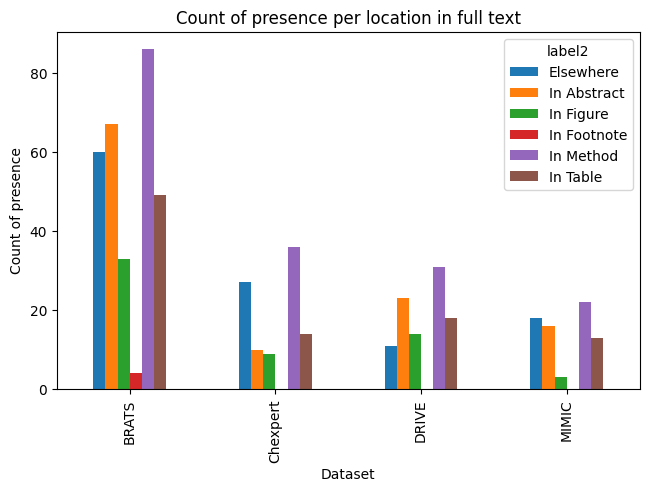

label2,Elsewhere,In Abstract,In Figure,In Footnote,In Method,In Table
label1,,,,,,
BRATS,60.0,67.0,33.0,4.0,86.0,49.0
Chexpert,27.0,10.0,9.0,0.0,36.0,14.0
DRIVE,11.0,23.0,14.0,0.0,31.0,18.0
MIMIC,18.0,16.0,3.0,0.0,22.0,13.0


In [63]:
df_dataset = df_detection[['label1','label2','value']].groupby(['label1','label2']).sum().unstack().fillna(0).droplevel(0,axis=1)
plt.figure()
df_dataset[df_dataset.index.isin(datasets_columns)].plot.bar()
plt.tight_layout()
plt.title("Count of presence per location in full text")
plt.xlabel('Dataset')
plt.ylabel('Count of presence')
plt.show()
df_dataset[df_dataset.index.isin(datasets_columns)]

## Mean number of references (not only dataset) per year in MICCAI

Text(0, 0.5, 'Mean number of references')

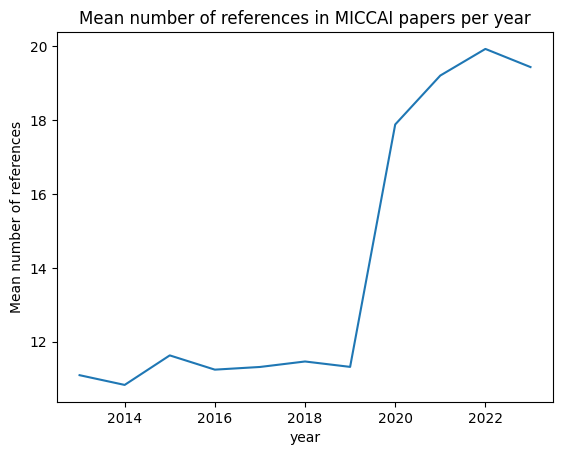

In [64]:
def number_of_reference(x):
    if x == x:
        list_ref = literal_eval(x)
        return len(list_ref)
    else:
        return 0
papers_info["nb_ref"] = papers_info["references"].apply(number_of_reference)
#df_oa.groupby(["venue","year"]).sum()["nb_ref"].unstack().fillna(0)["MICCAI"] / df_oa.groupby(["venue","year"]).sum()
plt.figure()
plt.title("Mean number of references in MICCAI papers per year")
(papers_info.groupby(["venue","year"]).sum()["nb_ref"].unstack().fillna(0).T["MICCAI"] / papers_info.groupby(["venue","year"]).size().unstack().fillna(0).T["MICCAI"]).plot()
plt.ylabel("Mean number of references")

## Number of citations per venue

<Axes: xlabel='venue'>

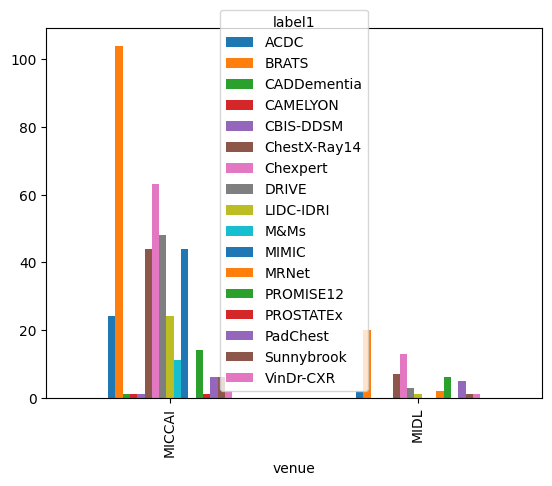

In [65]:
df_references[df_references["value"]].groupby(["venue","label1"]).count()["doc_name"].unstack().fillna(0).plot.bar()

## Number per group (With OpenAlex abstract, references, downloaded fulltext)

In [66]:
# papers_info["abstract"].isna() indicates if the abstract is present or not in openalex
len(papers_info[(papers_info["venue"].isin(selected_venues))&(~papers_info["abstract"].isna())&(~papers_info["references"].isna())&(papers_info["downloaded_fulltext"] == True)])

2312